In [33]:
import os
import numpy as np
import nibabel as nib
from scipy.stats import f
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
import nipype.interfaces.freesurfer as fs
import nipype.interfaces.utility as util
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from os.path import isfile, exists
import xlrd
Z = norm.ppf


%matplotlib inline

# Grab ROI mask and transform struct to func

In [34]:
#defining the workflow directories
subjects_dir = '/home/data/madlab/surfaces/seqtrd'
work_dir = '/scratch/madlab/seqtrd/anatroi_workdir/seqbl_lag_cic'
sink_dir = '/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic'

#subjects that we iterate over (functional data)
#sids = os.listdir('/home/data/madlab/data/mri/seqtrd/frstlvl/seqbl_1st_laganalysis')
#sids = ['783126']
#Subjects with OTcor and Repeat incor
sids = ['783126', '783127', '783128','783129', '783130', '783131', '783132', '783133', 
        '783135', '783136', '783137', '783138', '783139','783140','783141', '783142', '783144', '783146',
        '783147', '783148', '783149', '783150', '783151', '783152', '783153', '783154', '783155','783156',
        '783157', '783158', '783159', '783163']

#sids_no_OTcor = 783125, 783134, 783143
#thrown out sids = 783145, 783160, 783161, 783162 

wf = pe.Workflow(name='wf')
wf.base_dir = work_dir

# Node: subject_iterable
subj_iterable = pe.Node(util.IdentityInterface(fields=['subject_id'], mandatory_inputs=True),
                        name='subj_iterable')
subj_iterable.iterables = ('subject_id', sids)

# Grabbing data
info = dict(ref_epi_file=[['subject_id']],
            bbreg_xfm=[['subject_id']],
            hpc_ap_mask=[['subject_id']],
            aparc_aseg=[['subject_id']])

datasource = pe.Node(nio.DataGrabber(infields=['subject_id'],
                                     outfields=info.keys()),
                                     name='datasource')
datasource.inputs.base_directory = os.path.abspath('/home/data/madlab/')
datasource.inputs.field_template = dict(ref_epi_file='data/mri/seqtrd/preproc/%s/seq/ref/*.nii.gz',
                                        bbreg_xfm='data/mri/seqtrd/preproc/%s/seq/bbreg/_fs_register0/*.dat',
                                        hpc_ap_mask='data/mri/seqtrd/ant_post_hpc_mask/%s/mask_resample.nii.gz',
                                        aparc_aseg='surfaces/seqtrd/%s/mri/aparc+aseg.mgz')

#datasource.inputs.subject_id = sids[0]
datasource.inputs.template = '*'
datasource.inputs.template_args = info
datasource.inputs.sort_filelist = True
datasource.inputs.ignore_exception = False
datasource.inputs.raise_on_empty = True
wf.connect(subj_iterable, 'subject_id', datasource, 'subject_id')

# Extract anterior hippocampus (bilateral) as binary mask
ant_hpc_mask = pe.Node(fs.Binarize(), 
                       name='ant_hpc_mask')
ant_hpc_mask.inputs.match = [1, 21]
ant_hpc_mask.inputs.binary_file = 'ant_hpc.nii.gz'
wf.connect(datasource, 'hpc_ap_mask', ant_hpc_mask, 'in_file')

# Extract right anterior hippocampus as binary mask
r_ant_hpc_mask = pe.Node(fs.Binarize(), 
                       name='r_ant_hpc_mask')
r_ant_hpc_mask.inputs.match = [1]
r_ant_hpc_mask.inputs.binary_file = 'r_ant_hpc.nii.gz'
wf.connect(datasource, 'hpc_ap_mask', r_ant_hpc_mask, 'in_file')

# Extract left anterior hippocampus as binary mask
l_ant_hpc_mask = pe.Node(fs.Binarize(), 
                       name='l_ant_hpc_mask')
l_ant_hpc_mask.inputs.match = [21]
l_ant_hpc_mask.inputs.binary_file = 'l_ant_hpc.nii.gz'
#This is the outputfile name
wf.connect(datasource, 'hpc_ap_mask', l_ant_hpc_mask, 'in_file')


#Extract mPFC (bilateral) as binary mask
#1002 and 2002 are l and r caudalte anterior cingulate
#1026 and 2026 are the l and r rostral anterior cingulate
#2 hemispheres together
#Here we use the aparc_aseg file from freesurfer as input (Automatedparcellation and automated segmentation)
mpfc_mask = pe.Node(fs.Binarize(),
                   name='mpfc_mask')
mpfc_mask.inputs.match = [1002, 2002, 1026, 2026]
mpfc_mask.inputs.binary_file = 'mpfc_bimask.nii.gz'
wf.connect(datasource, 'aparc_aseg', mpfc_mask, 'in_file')


#Tansform from struct (surface) to epi
#anterior hpc
ant_hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
                                           interp='nearest'),
                      name='ant_hpc_xfm')
ant_hpc_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', ant_hpc_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', ant_hpc_xfm, 'reg_file')
wf.connect(ant_hpc_mask, 'binary_file', ant_hpc_xfm, 'target_file')

# Now transform the anterior HC binary mask to 1st volume of 1st run
#moving from freesurfer space into EPI space
r_ant_hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
                                           interp='nearest'),
                      name='r_ant_hpc_xfm')
r_ant_hpc_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', r_ant_hpc_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', r_ant_hpc_xfm, 'reg_file')
wf.connect(r_ant_hpc_mask, 'binary_file', r_ant_hpc_xfm, 'target_file')


l_ant_hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
                                           interp='nearest'),
                      name='l_ant_hpc_xfm')
l_ant_hpc_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', l_ant_hpc_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', l_ant_hpc_xfm, 'reg_file')
wf.connect(l_ant_hpc_mask, 'binary_file', l_ant_hpc_xfm, 'target_file')

# Now transform the mPFC mask to 1st volume of 1st run
mpfc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
                                           interp='nearest'),
                      name='mpfc_xfm')
mpfc_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', mpfc_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', mpfc_xfm, 'reg_file')
wf.connect(mpfc_mask, 'binary_file', mpfc_xfm, 'target_file')

# Node: sinker
#saves it
sinker = pe.Node(nio.DataSink(infields=None), name="sinker")
sinker.inputs._outputs = {}
sinker.inputs.base_directory = sink_dir
#container is the file it will be saved in 
#sinker.inputs.container = sids[0]
sinker.inputs.ignore_exception = False
sinker.inputs.parameterization = True
sinker.inputs.remove_dest_dir = False
wf.connect(subj_iterable, 'subject_id', sinker, 'container')
wf.connect(ant_hpc_xfm, "transformed_file", sinker, "anat_masks.@anthpc")
wf.connect(r_ant_hpc_xfm, "transformed_file", sinker, "anat_masks.@r_anthpc")
wf.connect(mpfc_xfm, "transformed_file", sinker, "anat_masks.@mpfc")

wf.run(plugin='SLURM', plugin_args={'sbatch_args': ('-p investor --qos pq_madlab -t 24:00:00 -N 1 -n 1 -e err -o out'), 'overwrite': True})

191125-11:28:23,787 workflow INFO:
	 Workflow wf settings: ['check', 'execution', 'logging']
191125-11:28:24,229 workflow INFO:
	 Running in parallel.
191125-11:28:24,244 workflow INFO:
	 Pending[0] Submitting[32] jobs Slots[inf]
191125-11:28:24,245 workflow INFO:
	 Submitting: datasource.a31 ID: 0
191125-11:28:24,408 workflow INFO:
	 Finished submitting: datasource.a31 ID: 0
191125-11:28:24,410 workflow INFO:
	 Submitting: datasource.a02 ID: 1
191125-11:28:24,594 workflow INFO:
	 Finished submitting: datasource.a02 ID: 1
191125-11:28:24,599 workflow INFO:
	 Submitting: datasource.a30 ID: 20
191125-11:28:24,812 workflow INFO:
	 Finished submitting: datasource.a30 ID: 20
191125-11:28:24,817 workflow INFO:
	 Submitting: datasource.a01 ID: 21
191125-11:28:25,24 workflow INFO:
	 Finished submitting: datasource.a01 ID: 21
191125-11:28:25,28 workflow INFO:
	 Submitting: datasource.a04 ID: 28
191125-11:28:25,235 workflow INFO:
	 Finished submitting: datasource.a04 ID: 28
191125-11:28:25,238 w

191125-11:28:54,242 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_mask.a19 jobid: 101
191125-11:28:54,247 workflow INFO:
	 Finished submitting: r_ant_hpc_mask.a19 ID: 101
191125-11:28:54,249 workflow INFO:
	 Submitting: l_ant_hpc_mask.a19 ID: 103
191125-11:28:54,281 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_mask.a19 jobid: 103
191125-11:28:54,286 workflow INFO:
	 Finished submitting: l_ant_hpc_mask.a19 ID: 103
191125-11:28:54,289 workflow INFO:
	 Submitting: r_ant_hpc_mask.a23 ID: 105
191125-11:28:54,324 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_mask.a23 jobid: 105
191125-11:28:54,329 workflow INFO:
	 Finished submitting: r_ant_hpc_mask.a23 ID: 105
191125-11:28:54,330 workflow INFO:
	 Submitting: r_ant_hpc_mask.a10 ID: 108
191125-11:28:54,367 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_mask.a10 jobid: 108
191125-11:28:54,372 workflow INFO:
	 Finished submitting: r_ant_hpc_mask.a10 ID: 108
191125-11:28:54,375 workflow INFO:
	 Submitting: l_ant_hpc_mask.a10 

191125-11:28:55,568 workflow INFO:
	 Finished submitting: l_ant_hpc_mask.a11 ID: 188
191125-11:28:55,572 workflow INFO:
	 Submitting: ant_hpc_mask.a03 ID: 192
191125-11:28:55,608 workflow INFO:
	 [Job finished] jobname: ant_hpc_mask.a03 jobid: 192
191125-11:28:55,613 workflow INFO:
	 Finished submitting: ant_hpc_mask.a03 ID: 192
191125-11:28:55,616 workflow INFO:
	 Submitting: l_ant_hpc_mask.a03 ID: 194
191125-11:28:55,648 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_mask.a03 jobid: 194
191125-11:28:55,653 workflow INFO:
	 Finished submitting: l_ant_hpc_mask.a03 ID: 194
191125-11:28:55,655 workflow INFO:
	 Submitting: mpfc_mask.a03 ID: 195
191125-11:28:55,687 workflow INFO:
	 [Job finished] jobname: mpfc_mask.a03 jobid: 195
191125-11:28:55,693 workflow INFO:
	 Finished submitting: mpfc_mask.a03 ID: 195
191125-11:28:55,695 workflow INFO:
	 Submitting: r_ant_hpc_mask.a11 ID: 199
191125-11:28:55,727 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_mask.a11 jobid: 199
191125-11:28:

191125-11:28:56,916 workflow INFO:
	 Submitting: mpfc_mask.a17 ID: 287
191125-11:28:56,949 workflow INFO:
	 [Job finished] jobname: mpfc_mask.a17 jobid: 287
191125-11:28:56,954 workflow INFO:
	 Finished submitting: mpfc_mask.a17 ID: 287
191125-11:28:56,957 workflow INFO:
	 Submitting: l_ant_hpc_mask.a22 ID: 290
191125-11:28:56,988 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_mask.a22 jobid: 290
191125-11:28:56,994 workflow INFO:
	 Finished submitting: l_ant_hpc_mask.a22 ID: 290
191125-11:28:56,996 workflow INFO:
	 Submitting: l_ant_hpc_mask.a05 ID: 292
191125-11:28:57,28 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_mask.a05 jobid: 292
191125-11:28:57,33 workflow INFO:
	 Finished submitting: l_ant_hpc_mask.a05 ID: 292
191125-11:28:57,35 workflow INFO:
	 Submitting: ant_hpc_mask.a22 ID: 294
191125-11:28:57,67 workflow INFO:
	 [Job finished] jobname: ant_hpc_mask.a22 jobid: 294
191125-11:28:57,73 workflow INFO:
	 Finished submitting: ant_hpc_mask.a22 ID: 294
191125-11:28:57,76

191125-11:28:59,481 workflow INFO:
	 [Job finished] jobname: mpfc_xfm.a23 jobid: 141
191125-11:28:59,486 workflow INFO:
	 Finished submitting: mpfc_xfm.a23 ID: 141
191125-11:28:59,488 workflow INFO:
	 Submitting: r_ant_hpc_xfm.a13 ID: 145
191125-11:28:59,576 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_xfm.a13 jobid: 145
191125-11:28:59,581 workflow INFO:
	 Finished submitting: r_ant_hpc_xfm.a13 ID: 145
191125-11:28:59,583 workflow INFO:
	 Submitting: l_ant_hpc_xfm.a13 ID: 147
191125-11:28:59,669 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_xfm.a13 jobid: 147
191125-11:28:59,674 workflow INFO:
	 Finished submitting: l_ant_hpc_xfm.a13 ID: 147
191125-11:28:59,676 workflow INFO:
	 Submitting: ant_hpc_xfm.a13 ID: 149
191125-11:28:59,762 workflow INFO:
	 [Job finished] jobname: ant_hpc_xfm.a13 jobid: 149
191125-11:28:59,767 workflow INFO:
	 Finished submitting: ant_hpc_xfm.a13 ID: 149
191125-11:28:59,769 workflow INFO:
	 Submitting: mpfc_xfm.a13 ID: 151
191125-11:28:59,855 workf

191125-11:29:02,502 workflow INFO:
	 Submitting: ant_hpc_xfm.a16 ID: 253
191125-11:29:02,588 workflow INFO:
	 [Job finished] jobname: ant_hpc_xfm.a16 jobid: 253
191125-11:29:02,593 workflow INFO:
	 Finished submitting: ant_hpc_xfm.a16 ID: 253
191125-11:29:02,597 workflow INFO:
	 Submitting: l_ant_hpc_xfm.a18 ID: 255
191125-11:29:02,683 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_xfm.a18 jobid: 255
191125-11:29:02,688 workflow INFO:
	 Finished submitting: l_ant_hpc_xfm.a18 ID: 255
191125-11:29:02,689 workflow INFO:
	 Submitting: l_ant_hpc_xfm.a00 ID: 257
191125-11:29:02,776 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_xfm.a00 jobid: 257
191125-11:29:02,781 workflow INFO:
	 Finished submitting: l_ant_hpc_xfm.a00 ID: 257
191125-11:29:02,783 workflow INFO:
	 Submitting: ant_hpc_xfm.a18 ID: 259
191125-11:29:02,868 workflow INFO:
	 [Job finished] jobname: ant_hpc_xfm.a18 jobid: 259
191125-11:29:02,873 workflow INFO:
	 Finished submitting: ant_hpc_xfm.a18 ID: 259
191125-11:29:02,

191125-11:29:07,408 workflow INFO:
	 Finished submitting: sinker.a12 ID: 179
191125-11:29:07,412 workflow INFO:
	 Submitting: sinker.a03 ID: 203
191125-11:29:07,706 workflow INFO:
	 Finished submitting: sinker.a03 ID: 203
191125-11:29:07,711 workflow INFO:
	 Submitting: sinker.a11 ID: 204
191125-11:29:08,6 workflow INFO:
	 Finished submitting: sinker.a11 ID: 204
191125-11:29:08,11 workflow INFO:
	 Submitting: sinker.a00 ID: 225
191125-11:29:08,311 workflow INFO:
	 Finished submitting: sinker.a00 ID: 225
191125-11:29:08,316 workflow INFO:
	 Submitting: sinker.a19 ID: 231
191125-11:29:08,611 workflow INFO:
	 Finished submitting: sinker.a19 ID: 231
191125-11:29:08,616 workflow INFO:
	 Submitting: sinker.a26 ID: 235
191125-11:29:08,956 workflow INFO:
	 Finished submitting: sinker.a26 ID: 235
191125-11:29:08,961 workflow INFO:
	 Submitting: sinker.a18 ID: 264
191125-11:29:09,312 workflow INFO:
	 Finished submitting: sinker.a18 ID: 264
191125-11:29:09,317 workflow INFO:
	 Submitting: sinker.

191125-11:29:21,373 workflow INFO:
	 [Job finished] jobname: ant_hpc_mask.a01 jobid: 36
191125-11:29:21,378 workflow INFO:
	 Finished submitting: ant_hpc_mask.a01 ID: 36
191125-11:29:21,381 workflow INFO:
	 Submitting: mpfc_mask.a01 ID: 38
191125-11:29:21,413 workflow INFO:
	 [Job finished] jobname: mpfc_mask.a01 jobid: 38
191125-11:29:21,419 workflow INFO:
	 Finished submitting: mpfc_mask.a01 ID: 38
191125-11:29:21,422 workflow INFO:
	 Submitting: mpfc_mask.a29 ID: 42
191125-11:29:21,453 workflow INFO:
	 [Job finished] jobname: mpfc_mask.a29 jobid: 42
191125-11:29:21,458 workflow INFO:
	 Finished submitting: mpfc_mask.a29 ID: 42
191125-11:29:21,461 workflow INFO:
	 Submitting: r_ant_hpc_mask.a28 ID: 45
191125-11:29:21,492 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_mask.a28 jobid: 45
191125-11:29:21,497 workflow INFO:
	 Finished submitting: r_ant_hpc_mask.a28 ID: 45
191125-11:29:21,499 workflow INFO:
	 Submitting: l_ant_hpc_mask.a28 ID: 47
191125-11:29:21,532 workflow INFO:
	 [

191125-11:29:22,874 workflow INFO:
	 Finished submitting: ant_hpc_xfm.a31 ID: 9
191125-11:29:22,876 workflow INFO:
	 Submitting: l_ant_hpc_xfm.a02 ID: 11
191125-11:29:22,963 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_xfm.a02 jobid: 11
191125-11:29:22,968 workflow INFO:
	 Finished submitting: l_ant_hpc_xfm.a02 ID: 11
191125-11:29:22,970 workflow INFO:
	 Submitting: mpfc_xfm.a31 ID: 13
191125-11:29:23,52 workflow INFO:
	 [Job finished] jobname: mpfc_xfm.a31 jobid: 13
191125-11:29:23,57 workflow INFO:
	 Finished submitting: mpfc_xfm.a31 ID: 13
191125-11:29:23,58 workflow INFO:
	 Submitting: ant_hpc_xfm.a02 ID: 16
191125-11:29:23,133 workflow INFO:
	 [Job finished] jobname: ant_hpc_xfm.a02 jobid: 16
191125-11:29:23,137 workflow INFO:
	 Finished submitting: ant_hpc_xfm.a02 ID: 16
191125-11:29:23,140 workflow INFO:
	 Submitting: mpfc_xfm.a02 ID: 18
191125-11:29:23,213 workflow INFO:
	 [Job finished] jobname: mpfc_xfm.a02 jobid: 18
191125-11:29:23,217 workflow INFO:
	 Finished submitt

191125-11:29:25,995 workflow INFO:
	 Submitting: r_ant_hpc_xfm.a29 ID: 215
191125-11:29:26,83 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_xfm.a29 jobid: 215
191125-11:29:26,88 workflow INFO:
	 Finished submitting: r_ant_hpc_xfm.a29 ID: 215
191125-11:29:26,90 workflow INFO:
	 Submitting: l_ant_hpc_xfm.a29 ID: 228
191125-11:29:26,176 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_xfm.a29 jobid: 228
191125-11:29:26,181 workflow INFO:
	 Finished submitting: l_ant_hpc_xfm.a29 ID: 228
191125-11:29:26,183 workflow INFO:
	 Submitting: l_ant_hpc_xfm.a24 ID: 233
191125-11:29:26,269 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_xfm.a24 jobid: 233
191125-11:29:26,274 workflow INFO:
	 Finished submitting: l_ant_hpc_xfm.a24 ID: 233
191125-11:29:26,277 workflow INFO:
	 Submitting: ant_hpc_xfm.a24 ID: 237
191125-11:29:26,362 workflow INFO:
	 [Job finished] jobname: ant_hpc_xfm.a24 jobid: 237
191125-11:29:26,368 workflow INFO:
	 Finished submitting: ant_hpc_xfm.a24 ID: 237
191125-11:29:

# Next we grab the functional data for each condition

In [35]:
mask_filenames[4]

['/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783130/anat_masks/_subject_id_783130/mpfc_bimask_warped.nii.gz',
 '/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783130/anat_masks/_subject_id_783130/ant_hpc_warped.nii.gz',
 '/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783130/anat_masks/_subject_id_783130/r_ant_hpc_warped.nii.gz']

In [36]:
proj_dir = '/home/data/madlab/data/mri/seqtrd'

#sids = sorted(os.listdir('/home/data/madlab/data/mri/seqtrd/scndlvl/seq_1stpos_laganalysis_July23/'))

#making cope variables
mask_filenames = []
cope_Lin_skp_pos1topos3_files = []
cope_NegLin_skp_pos3topos1_files = []
cope_otincorr_gt_otcorr_files = []
cope_otcorr_gt_otincorr_files = []
cope_skipincorr_gt_skipcorr_files = []
cope_skipcorr_gt_skipincorr_files = []


#right now its grabbing the masks from the sink dir

for SID in sids:
    mask_filenames_glob = glob('/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/' + SID + '/anat_masks/*/*')
    mask_filenames.append(mask_filenames_glob)
    
    #Lin_skp_pos1topos3
    curr_LinSkp_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_laganalysis_July23/' + SID + '/fixedfx/cope_Lin_skp_pos1topos3.nii.gz')
    cope_Lin_skp_pos1topos3_files.append(curr_LinSkp_filenames_glob)     

    #NegLin_skp_pos3topos1
    curr_NegLinSkp_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_laganalysis_July23/' + SID + '/fixedfx/cope_Lin_skp_pos3topos1.nii.gz')
    cope_NegLin_skp_pos3topos1_files.append(curr_NegLinSkp_filenames_glob) 
    
    
    # OT not detect minus OT detect
    curr_OT_incorr_minus_corr_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_OTIncorr_minus_OTCorr.nii.gz')
    cope_otincorr_gt_otcorr_files.append(curr_OT_incorr_minus_corr_filenames_glob)
    
    # OT detect minus OT not detect (OT CIC)
    curr_OT_corr_minus_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_OTCorr_minus_OTIncorr.nii.gz')
    cope_otcorr_gt_otincorr_files.append(curr_OT_corr_minus_incorr_filenames_glob)
    
    # Skip incorr minus corr
    curr_skip_incorr_minus_corr_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_skipIncorr_minus_SkipCorr.nii.gz')
    cope_skipincorr_gt_skipcorr_files.append(curr_skip_incorr_minus_corr_filenames_glob)
    
    # Skip corr minus incorr
    curr_skip_corr_minus_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_SkipCorr_minus_SkipIncorr.nii.gz')
    cope_skipcorr_gt_skipincorr_files.append(curr_skip_corr_minus_incorr_filenames_glob)
    

In [37]:
mask_filenames[5]

['/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783131/anat_masks/_subject_id_783131/mpfc_bimask_warped.nii.gz',
 '/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783131/anat_masks/_subject_id_783131/ant_hpc_warped.nii.gz',
 '/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783131/anat_masks/_subject_id_783131/r_ant_hpc_warped.nii.gz']

# Now we grab the func data for each condition within the brainmask

In [38]:
all_data = {'subjid':[], 
            'anthpc_linskp':[],'anthpc_Neglinskp':[],
            'mpfc_linskp':[],'mpfc_Neglinskp':[],
            'r_anthpc_linskp':[],'r_anthpc_Neglinskp':[],
            'mpfc_ot_icc':[],'mpfc_ot_cic':[],
            'anthpc_ot_icc':[],'anthpc_ot_cic':[],
            'r_anthpc_ot_icc':[],'r_anthpc_ot_cic':[]}

for i in range(len(sids)):
    all_data['subjid'].append(sids[i])
    
    #What are these numbers? They come from the cell before from glob. The mpfc for example is the second one in the list.
    #and the left anthpc is the 5th one in the list as you can se a
    
#masks = dict(r_anthpc_img_mask = glob('/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/wf/_subject_id_' + i + '/r_ant_hpc_xfm/r_ant_hpc_warped.nii.gz')
#             mpfc_img_mask = glob('/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/wf/_subject_id_' + i + '/mpfc_xfm/mpfc_bimask_warped.nii.gz')
#             anthpc_img_mask = glob('/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/wf/_subject_id_' + i + '/ant_hpc_xfm/ant_hpc_warped.nii.gz') 
#            )

#    currsubj_r_anthpc_img = nib.load(r_anthpc_img_mask)
#    currsubj_mpfc_img = nib.load(mpfc_img_mask)
#    currsubj_anthpc_img = nib.load(anthpc_img_mask)
    
    currsubj_anthpc_img = nib.load(mask_filenames[i][1])
    currsubj_mpfc_img = nib.load(mask_filenames[i][0])
    currsubj_r_anthpc_img = nib.load(mask_filenames[i][2])
    
    #****************Linear analysis (and neg linear analysis) in ant HC********************
    #Here nibabel converts 3D or 4D data into a numpy array
    #getting functional data within the mask
    # anterior hpc linskip
    if len(cope_Lin_skp_pos1topos3_files[i]) == 0:
        all_data['anthpc_linskp'].append(np.nan)
    else:
        currsubj_linskp_img = nib.load(cope_Lin_skp_pos1topos3_files[i][0])
        currsubj_anthpc_linskip_data = currsubj_linskp_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
        all_data['anthpc_linskp'].append(np.mean(currsubj_anthpc_linskip_data))
    
    # anterior hpc neglinskip
    if len(cope_NegLin_skp_pos3topos1_files[i]) == 0:
        all_data['anthpc_Neglinskp'].append(np.nan)
    else:
        currsubj_Neglinskp_img = nib.load(cope_NegLin_skp_pos3topos1_files[i][0])
        currsubj_anthpc_Neglinskip_data = currsubj_Neglinskp_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
        all_data['anthpc_Neglinskp'].append(np.mean(currsubj_anthpc_Neglinskip_data))
        
        
    #****************Linear analysis (and neg linear analysis) in ant HC********************
    if len(cope_Lin_skp_pos1topos3_files[i]) == 0:
        all_data['mpfc_linskp'].append(np.nan)
    else:
        currsubj_linskp_img = nib.load(cope_Lin_skp_pos1topos3_files[i][0])
        currsubj_mpfc_linskip_data = currsubj_linskp_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
        all_data['mpfc_linskp'].append(np.mean(currsubj_mpfc_linskip_data))
        
    if len(cope_NegLin_skp_pos3topos1_files[i]) == 0:
        all_data['mpfc_Neglinskp'].append(np.nan)
    else:
        currsubj_Neglinskp_img = nib.load(cope_NegLin_skp_pos3topos1_files[i][0])
        currsubj_mpfc_Neglinskip_data = currsubj_Neglinskp_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
        all_data['mpfc_Neglinskp'].append(np.mean(currsubj_mpfc_Neglinskip_data))
        
        
    #****************Linear analysis in right ant HC only********************
    if len(cope_Lin_skp_pos1topos3_files[i]) == 0:
        all_data['r_anthpc_linskp'].append(np.nan)
    else:
        currsubj_linskp_img = nib.load(cope_Lin_skp_pos1topos3_files[i][0])
        currsubj_r_anthpc_linskip_data = currsubj_linskp_img.get_data()[currsubj_r_anthpc_img.get_data() > 0.]
        all_data['r_anthpc_linskp'].append(np.mean(currsubj_r_anthpc_linskip_data))
        
    if len(cope_NegLin_skp_pos3topos1_files[i]) == 0:
        all_data['r_anthpc_Neglinskp'].append(np.nan)
    else:
        currsubj_Neglinskp_img = nib.load(cope_NegLin_skp_pos3topos1_files[i][0])
        currsubj_r_anthpc_Neglinskip_data = currsubj_Neglinskp_img.get_data()[currsubj_r_anthpc_img.get_data() > 0.]
        all_data['r_anthpc_Neglinskp'].append(np.mean(currsubj_r_anthpc_Neglinskip_data))
        
        


    #****************ICC and CIC for OT, REP, and Skip in mPFC*********************
        
    if len(cope_otincorr_gt_otcorr_files[i]) == 0:
        all_data['mpfc_ot_icc'].append(np.nan)
    else:
        currsubj_ot_icc_img = nib.load(cope_otincorr_gt_otcorr_files[i][0])
        currsubj_mpfc_ot_icc_data = currsubj_ot_icc_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
        all_data['mpfc_ot_icc'].append(np.mean(currsubj_mpfc_ot_icc_data))
        
    if len(cope_otcorr_gt_otincorr_files[i]) == 0:
        all_data['mpfc_ot_cic'].append(np.nan)
    else:
        currsubj_ot_cic_img = nib.load(cope_otcorr_gt_otincorr_files[i][0])
        currsubj_mpfc_ot_cic_data = currsubj_ot_cic_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
        all_data['mpfc_ot_cic'].append(np.mean(currsubj_mpfc_ot_cic_data))

        
        
        #****************ICC and CIC for OT, REP, and Skip in the anterior HC*********************
    if len(cope_otincorr_gt_otcorr_files[i]) == 0:
        all_data['anthpc_ot_icc'].append(np.nan)
    else:
        currsubj_ot_icc_img = nib.load(cope_otincorr_gt_otcorr_files[i][0])
        currsubj_anthpc_ot_icc_data = currsubj_ot_icc_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
        all_data['anthpc_ot_icc'].append(np.mean(currsubj_anthpc_ot_icc_data))
        
    if len(cope_otcorr_gt_otincorr_files[i]) == 0:
        all_data['anthpc_ot_cic'].append(np.nan)
    else:
        currsubj_ot_cic_img = nib.load(cope_otcorr_gt_otincorr_files[i][0])
        currsubj_anthpc_ot_cic_data = currsubj_ot_cic_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
        all_data['anthpc_ot_cic'].append(np.mean(currsubj_anthpc_ot_cic_data))
        
    
        #***************** OT CIC and ICC for the right anterior HC**********
    if len(cope_otincorr_gt_otcorr_files[i]) == 0:
        all_data['r_anthpc_ot_icc'].append(np.nan)
    else:
        currsubj_ot_icc_img = nib.load(cope_otincorr_gt_otcorr_files[i][0])
        currsubj_r_anthpc_ot_icc_data = currsubj_ot_icc_img.get_data()[currsubj_r_anthpc_img.get_data() > 0.]
        all_data['r_anthpc_ot_icc'].append(np.mean(currsubj_r_anthpc_ot_icc_data))
        
    if len(cope_otcorr_gt_otincorr_files[i]) == 0:
        all_data['r_anthpc_ot_cic'].append(np.nan)
    else:
        currsubj_ot_cic_img = nib.load(cope_otcorr_gt_otincorr_files[i][0])
        currsubj_r_anthpc_ot_cic_data = currsubj_ot_cic_img.get_data()[currsubj_r_anthpc_img.get_data() > 0.]
        all_data['r_anthpc_ot_cic'].append(np.mean(currsubj_r_anthpc_ot_cic_data))
        
        


all_data_df = pd.DataFrame(all_data)
all_data_df.index = sids

In [40]:
all_data_df.describe()

,anthpc_Neglinskp,anthpc_linskp,anthpc_ot_cic,anthpc_ot_icc,mpfc_Neglinskp,mpfc_linskp,mpfc_ot_cic,mpfc_ot_icc,r_anthpc_Neglinskp,r_anthpc_linskp,r_anthpc_ot_cic,r_anthpc_ot_icc
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,-0.691281,0.691281,0.255654,-0.255654,-0.373508,0.373508,-0.708283,0.708283,-0.700449,0.700449,0.317673,-0.317673
std,1.462866,1.462866,1.767223,1.767223,2.707340,2.707340,1.997546,1.997546,1.530128,1.530128,2.121140,2.121140
min,-3.989777,-2.927037,-2.792696,-5.407541,-6.163204,-6.194607,-4.435409,-6.634796,-4.440678,-2.921455,-2.412018,-8.294138
25%,-1.473390,-0.176267,-0.977254,-0.944387,-2.155399,-1.115111,-1.597384,-0.189479,-1.369375,-0.125082,-0.913625,-0.974303
50%,-0.814009,0.814009,-0.213476,0.213476,-0.677485,0.677485,-1.033342,1.033342,-0.931289,0.931289,-0.319924,0.319924
75%,0.176267,1.473390,0.944387,0.977254,1.115111,2.155399,0.189479,1.597384,0.125082,1.369375,0.974303,0.913625
max,2.927037,3.989777,5.407541,2.792696,6.194607,6.163204,6.634796,4.435409,2.921455,4.440678,8.294138,2.412018


In [41]:
all_data_df

,anthpc_Neglinskp,anthpc_linskp,anthpc_ot_cic,anthpc_ot_icc,mpfc_Neglinskp,mpfc_linskp,mpfc_ot_cic,mpfc_ot_icc,r_anthpc_Neglinskp,r_anthpc_linskp,r_anthpc_ot_cic,r_anthpc_ot_icc,subjid
783126,2.927037,-2.927037,-1.505396,1.505396,1.651808,-1.651808,-3.231153,3.231153,1.087243,-1.087243,-1.387967,1.387967,783126
783127,1.305027,-1.305027,0.147205,-0.147205,2.081207,-2.081207,-0.677560,0.677560,0.972784,-0.972784,-0.222159,0.222159,783127
783128,0.094342,-0.094342,-0.955236,0.955236,0.952310,-0.952310,0.658121,-0.658121,-0.092382,0.092382,-0.905616,0.905616,783128
783129,-1.926620,1.926620,1.583104,-1.583104,-2.538787,2.538787,-1.594920,1.594920,-2.701478,2.701478,0.936295,-0.936295,783129
783130,-3.989777,3.989777,-0.193716,0.193716,-2.325596,2.325596,-2.791681,2.791681,-4.440678,4.440678,-0.688728,0.688728,783130
783131,-2.842944,2.842944,0.350060,-0.350060,-2.914144,2.914144,-3.643683,3.643683,-2.230186,2.230186,0.266098,-0.266098,783131
783132,0.235107,-0.235107,0.327605,-0.327605,2.251762,-2.251762,-1.587440,1.587440,0.237680,-0.237680,0.081758,-0.081758,783132
783133,-3.110952,3.110952,2.036729,-2.036729,-0.863712,0.863712,-1.950312,1.950312,-2.886826,2.886826,2.963079,-2.963079,783133
783135,-0.838872,0.838872,1.923884,-1.923884,0.707924,-0.707924,-1.267139,1.267139,-0.005667,0.005667,2.423178,-2.423178,783135
783136,-1.755715,1.755715,-1.113127,1.113127,-0.352073,0.352073,-1.308052,1.308052,-1.759501,1.759501,-1.320108,1.320108,783136


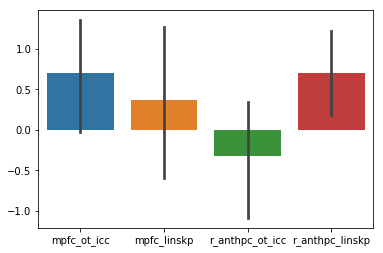

In [47]:
import seaborn as sns
ax = sns.barplot(data=all_data_df[['mpfc_ot_icc', 'mpfc_linskp', 'r_anthpc_ot_icc', 'r_anthpc_linskp']])

In [48]:
all_data_df.to_csv('/home/data/madlab/data/mri/seqtrd/BrainregionXStrategy_interaction_data.csv')